In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def compute_mean(sample):
    dimension = sample.shape[0]
    sum_vector = np.zeros((dimension,1))
    sum_vector = sum_vector.flatten('F') 
    
    for x in range(sample.shape[1]):
        sum_vector = sum_vector + sample[:,x].flatten('F')

    return (sum_vector/sample.shape[1]).T

In [16]:
def compute_cov(sample):
    mean = compute_mean(sample)
    dimension = sample.shape[0]
    err_sum_vector = np.zeros((dimension, dimension))
    
    for x in range(sample.shape[1]):
        err_vector = sample[:,x].flatten('F').T - mean
        err_sum_vector = err_sum_vector + np.dot(err_vector, err_vector.T)
        
    return (err_sum_vector/(sample.shape[1]-1))

In [17]:
def compute_prior(samples):
    total_sample = 0
    for sample in samples:
        total_sample = total_sample + sample.shape[1]
        
    prior = []
    for sample in samples:
        prior.append(sample.shape[1]/total_sample)
        
    return prior

In [18]:
train_cat = np.matrix(np.loadtxt('train_cat.txt', delimiter = ','))
train_grass = np.matrix(np.loadtxt('train_grass.txt', delimiter = ','))

cat_mean = compute_mean(train_cat)
grass_mean = compute_mean(train_grass)
cat_cov = compute_cov(train_cat)
grass_cov = compute_cov(train_grass)
prior_prob = compute_prior([train_grass, train_cat])

In [21]:
params = [{
    'class': 'grass',
    'value': 0,
    'mean': grass_mean,
    'cov': grass_cov,
    'inv_cov': np.linalg.inv(grass_cov),
    'det_cov': np.linalg.det(grass_cov),
    'log_det_cov': (1/2) * np.log(np.linalg.det(grass_cov)),
    'prior_prob': prior_prob[0],
    'log_prior_prob': np.log(prior_prob[0])
    }, {
    'class': 'cat',
    'value': 1,
    'mean': cat_mean,
    'cov': cat_cov,
    'inv_cov': np.linalg.inv(cat_cov),
    'det_cov': np.linalg.det(cat_cov),
    'log_det_cov': (1/2) * np.log(np.linalg.det(cat_cov)),
    'prior_prob': prior_prob[1],
    'log_prior_prob': np.log(prior_prob[1])
    }]

In [43]:
d = train_cat.shape[0]
pi_term = (d/2) * np.log(2*np.pi)
W = params[0]['inv_cov'] - params[1]['inv_cov']
w = np.dot(params[1]['inv_cov'], params[1]['mean']) - np.dot(params[0]['inv_cov'], params[0]['mean'])

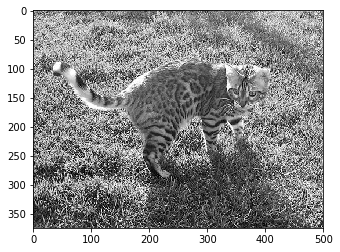

In [23]:
original_image = plt.imread('cat_grass.jpg') / 255
plt.imshow(original_image*255, cmap = 'gray')

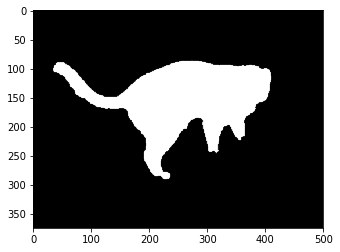

In [30]:
ground_truth = plt.imread('truth.png')  
plt.imshow(ground_truth, cmap = 'gray')

In [176]:
def g_x(x, param):
    diff = (x - param['mean'])
    return (param['log_prior_prob']
            - pi_term
            - param['log_det_cov']
            - (1/2) * np.dot(diff.T, np.dot(param['inv_cov'], diff)))[0, 0]

In [214]:
def gradient(x, x_0, lamb, target_index, params):
    g = []
    for param in params:
        g.append(g_x(x, param))
    if g[target_index] == max(g):
        print('glass image')
        return 0
    else:
        value = 2*(x - x_0) + lamb*(np.dot(W, x) + w) 
        return value


In [548]:
def cw_attack(x, lamb, target_index, params, alpha):
    g = []
    for param in params:
        g.append(g_x(x, param))
    if g[target_index] == max(g):
        return x
    else:
        x_0 = x
        current_x = x
        for i in range(100):
            gradient_value = 2*(x - x_0) + lamb*(np.dot(W, x) + w) 
            new_x = current_x - alpha*gradient_value
            new_x = np.clip(new_x, 0, 1)
            if np.linalg.norm(new_x - current_x) < 0.001:
                return new_x
            else: 
                current_x = new_x
        return current_x

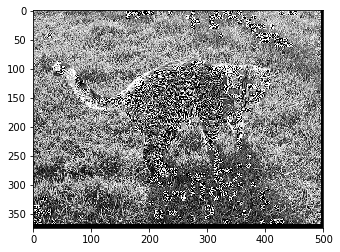

In [558]:
non_overlap = np.zeros((original_image.shape[0], original_image.shape[1]))
for i in range(original_image.shape[0]):
    if (i % 8) != 0 or i+8 >= original_image.shape[0]:
        continue
    for j in range(original_image.shape[1]):
        if (j % 8) != 0 or j+8 >= original_image.shape[1]:
            continue
        x = original_image[i:i+8, j:j+8]
        x = x.reshape((d, 1))
#         value = x.reshape((8, 8))
        value = cw_attack(x, 1, 0, params, 0.001).reshape((8, 8))
        non_overlap[i:i+8, j:j+8] = value
plt.imshow(non_overlap, cmap = 'gray')

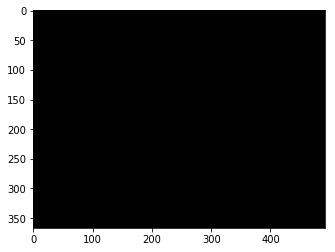

In [559]:
non_overlap_test = np.zeros((original_image.shape[0]-8, original_image.shape[1]-8))
for i in range(original_image.shape[0]-8):
    if (i % 8) != 0 or i+8 >= original_image.shape[0]-8:
        continue
    for j in range(original_image.shape[1]-8):
        if (j % 8) != 0 or j+8 >= original_image.shape[1]-8:
            continue
        x = non_overlap[i:i+8, j:j+8]
        x = x.reshape((d, 1))
        g_glass = g_x(x, params[0])
        g_cat = g_x(x, params[1])
        
        if g_glass > g_cat:
            value = 0
        else:
            value = 1
        
        for m in range(8):
             for n in range(8):
                try:
                    non_overlap_test[i+m, j+n] = value
                except IndexError:
                    print(f'({i}+{m}, {j}+{n})')
plt.imshow(non_overlap_test, cmap = 'gray')
plt.savefig("final_2_4_2.pdf") 

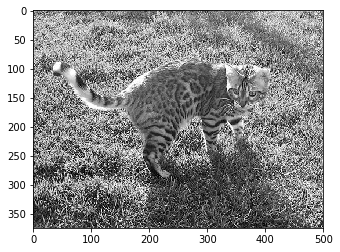

In [527]:
plt.imshow(original_image, cmap = 'gray')

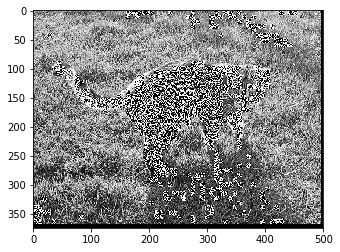

In [528]:
plt.imshow(non_overlap, cmap = 'gray')
plt.savefig("final_2_3_1.pdf") 

In [529]:
print(original_image)

[[0.62745098 0.28627451 0.46666667 ... 0.48627451 0.54117647 0.34901961]
 [0.62745098 0.34117647 0.70980392 ... 0.62745098 0.39607843 0.24313725]
 [0.4745098  0.51372549 0.80784314 ... 0.59607843 0.30588235 0.59607843]
 ...
 [0.57254902 0.69411765 0.19215686 ... 0.98823529 0.10588235 0.        ]
 [0.43137255 0.77647059 0.21960784 ... 0.90980392 0.51372549 0.36078431]
 [0.37254902 0.49411765 0.41568627 ... 0.41568627 0.66666667 0.77647059]]


In [530]:
print(non_overlap[:368,:496])

[[0.62745098 0.28627451 0.46666667 ... 0.27843137 0.83137255 0.45098039]
 [0.62745098 0.34117647 0.70980392 ... 0.77647059 0.71764706 0.24705882]
 [0.4745098  0.51372549 0.80784314 ... 0.94509804 0.03529412 0.36862745]
 ...
 [0.         0.         0.         ... 0.84313725 0.90196078 0.21176471]
 [1.         0.6038459  0.         ... 0.78039216 0.95686275 0.62745098]
 [0.         1.         0.24549002 ... 0.92941176 0.66666667 0.33333333]]


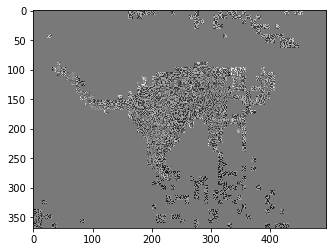

In [553]:
purturb = original_image[:368,:496]-non_overlap[:368,:496]
plt.imshow(purturb, cmap = 'gray')
# plt.savefig("final_2_3_2.pdf") 

In [560]:
print(np.linalg.norm(purturb))

64.95154221244961
